In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt

In [2]:
rates = pd.read_csv('data/Radioactivity in the ground at 2 hourly intervals over one year July 2.csv')
rates = rates.rename(columns={'Unnamed: 0': 'Time'})

data = rates.set_index('Time').sort_index()

In [3]:
data['MA_window_3'] = data['dose_rate'].rolling(window=3).mean()
data

,dose_rate,MA_window_3
Time,,
1,0.099992,NaN
2,0.099169,NaN
3,0.103160,0.100773
4,0.106554,0.102961
5,0.101224,0.103646
...,...,...
4366,0.107107,0.106756
4367,0.106559,0.106301
4368,0.105592,0.106419


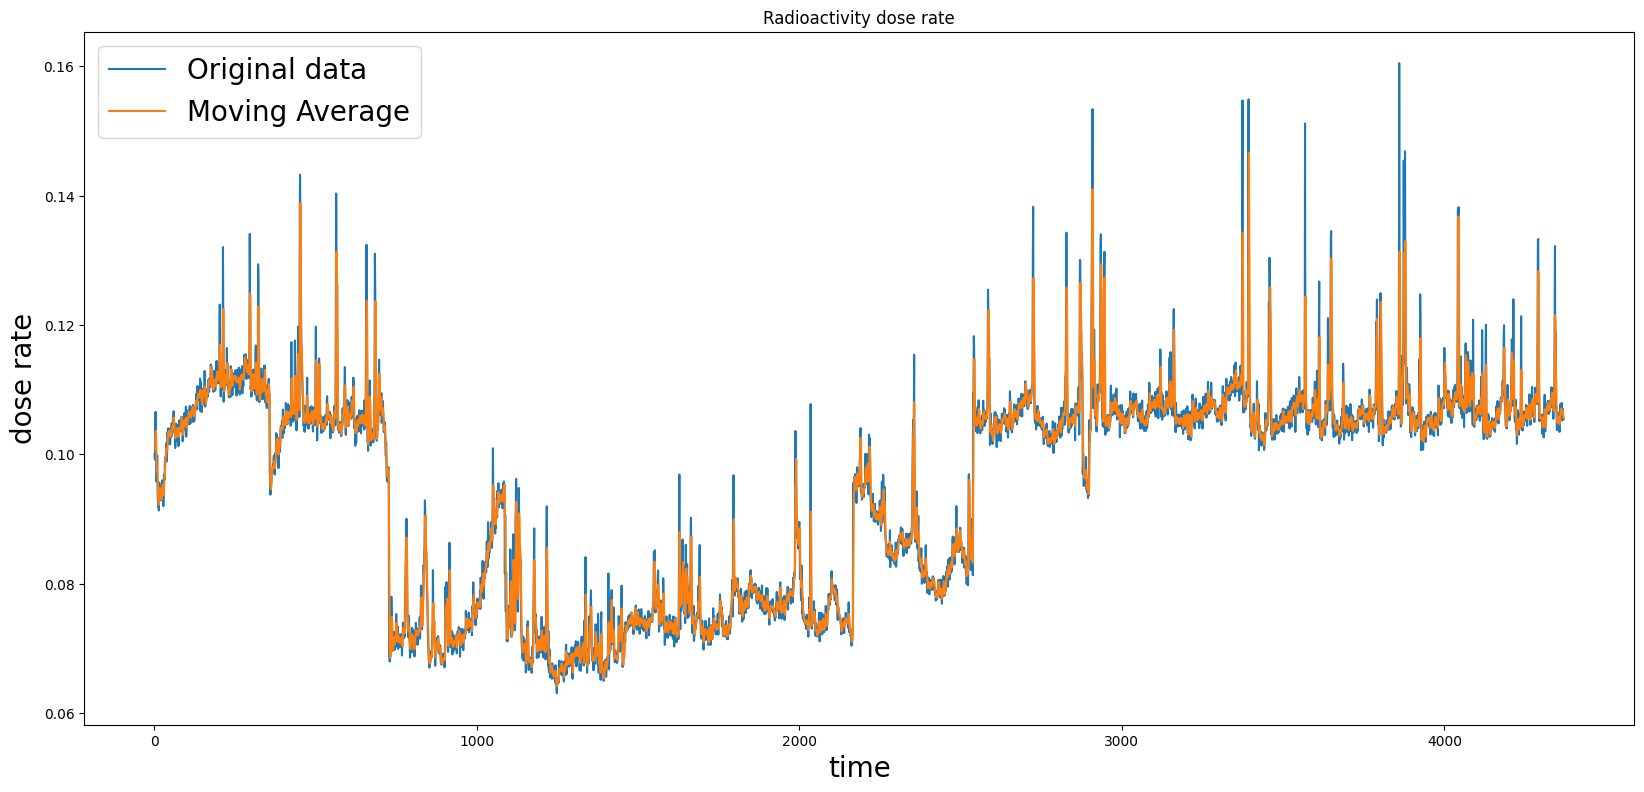

In [4]:
fig = plt.figure(figsize=(20, 9))
plt.plot(data['dose_rate'], label='Original data')
plt.plot(data['MA_window_3'], label='Moving Average')

plt.legend(fontsize="20")
plt.title('Radioactivity dose rate')
plt.ylabel('dose rate', fontsize="20")
plt.xlabel('time', fontsize="20")

plt.show()

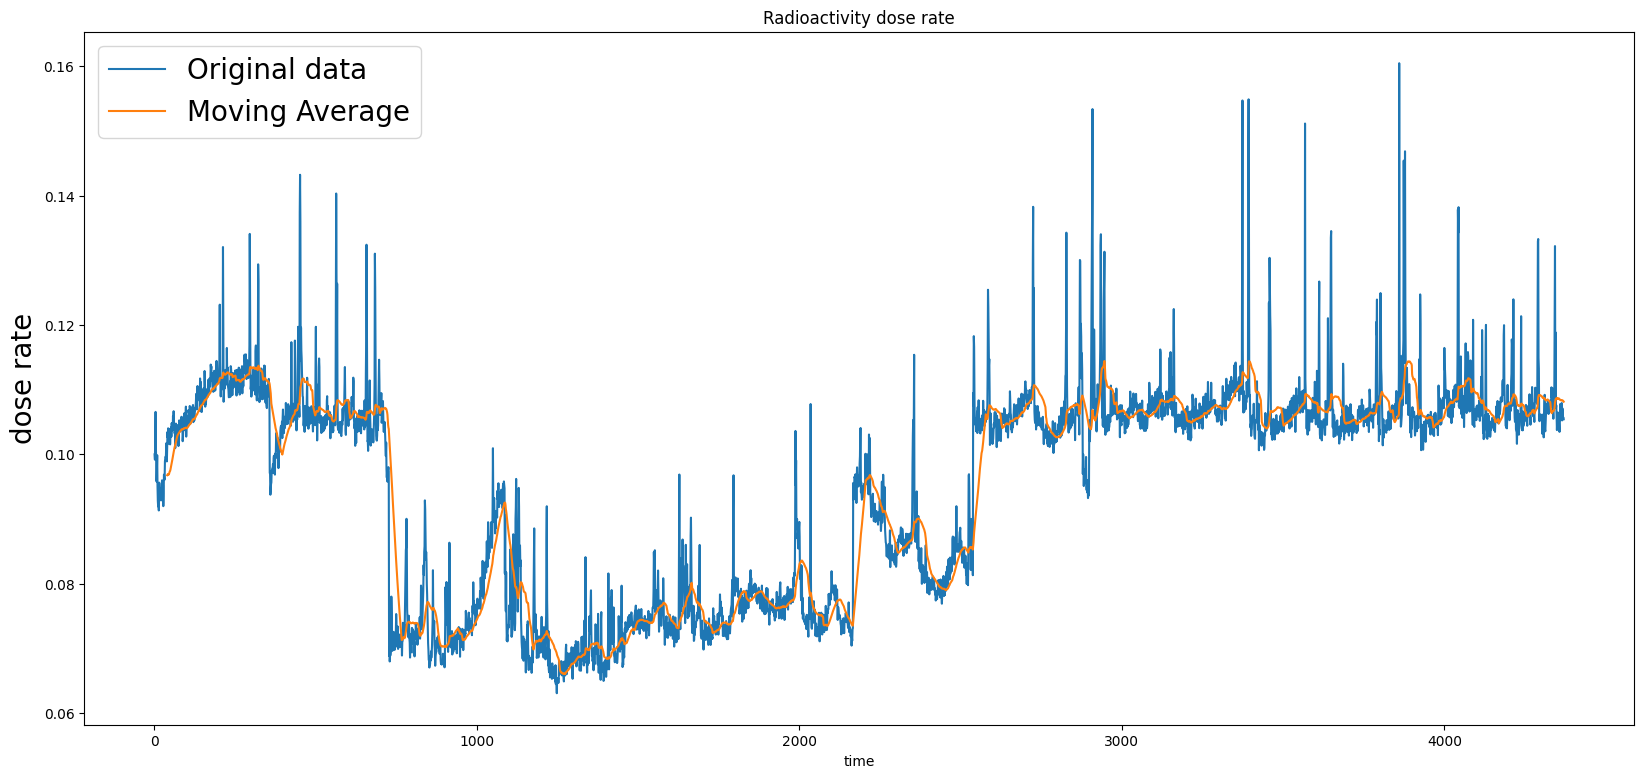

In [5]:
data['MA_window_40'] = data['dose_rate'].rolling(window=40).mean()

fig = plt.figure(figsize=(20, 9))
plt.plot(data['dose_rate'], label='Original data')
plt.plot(data['MA_window_40'], label='Moving Average')

plt.legend(fontsize="20")
plt.title('Radioactivity dose rate')
plt.ylabel('dose rate', fontsize="20")
plt.xlabel('time')

plt.show()

In [6]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=100,
            figsize=(15,5)):
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)
    plt.title(ts.name)
    plt.plot(ts[window:], label='Реальные значения', color="black")
    if plot_ma:
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
                 color="red")
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                     color='lightskyblue', alpha=0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

C:\Users\elise\AppData\Local\Temp\ipykernel_13084\2820275210.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window),


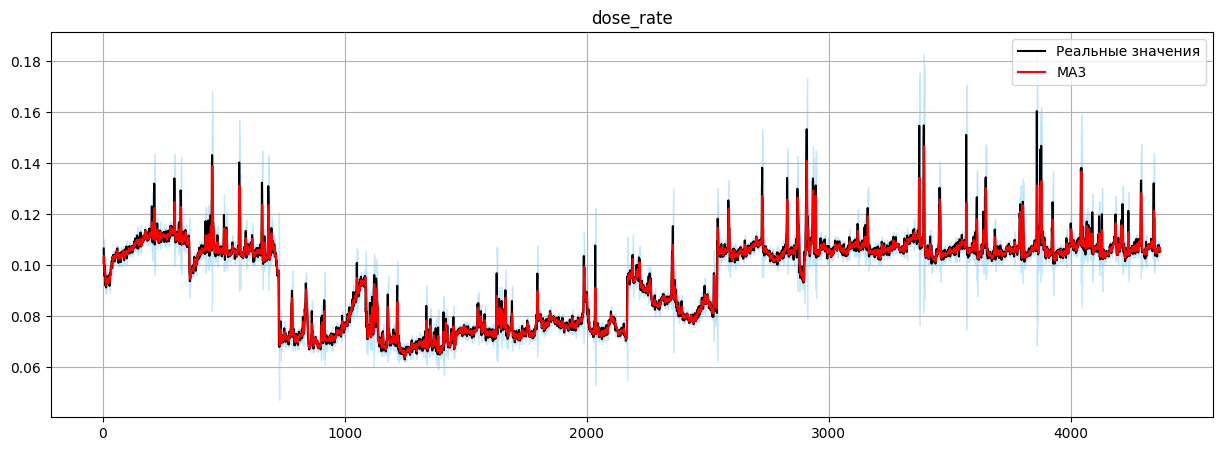

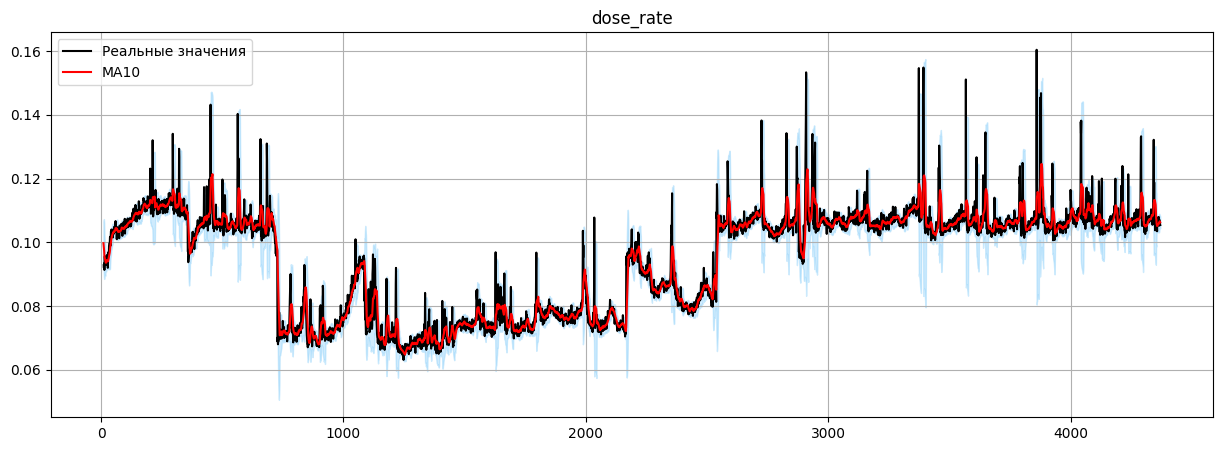

In [7]:
plot_ts(data["dose_rate"], window=3)
plot_ts(data["dose_rate"], window=10)

In [8]:
from statsmodels.tsa.arima.model import ARIMA

arma_model = ARIMA(data['dose_rate'], order=(5,0,3))
arma_model_fit = arma_model.fit()

print(arma_model_fit.summary())

c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              dose_rate   No. Observations:                 4370
Model:                 ARIMA(5, 0, 3)   Log Likelihood               18370.986
Date:                Wed, 22 Nov 2023   AIC                         -36721.972
Time:                        18:26:32   BIC                         -36658.147
Sample:                             0   HQIC                        -36699.449
                               - 4370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0949      0.008     11.293      0.000       0.078       0.111
ar.L1          0.3469      0.107      3.250      0.001       0.138       0.556
ar.L2          0.5144      0.123      4.197      0.0

In [10]:
X = data['dose_rate'].values

size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]

arma_predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    
    obs = test[t]
    history.append(obs)

c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

In [11]:
print(len(train))
print(len(test))
print(len(arma_predictions))

4151
219
219


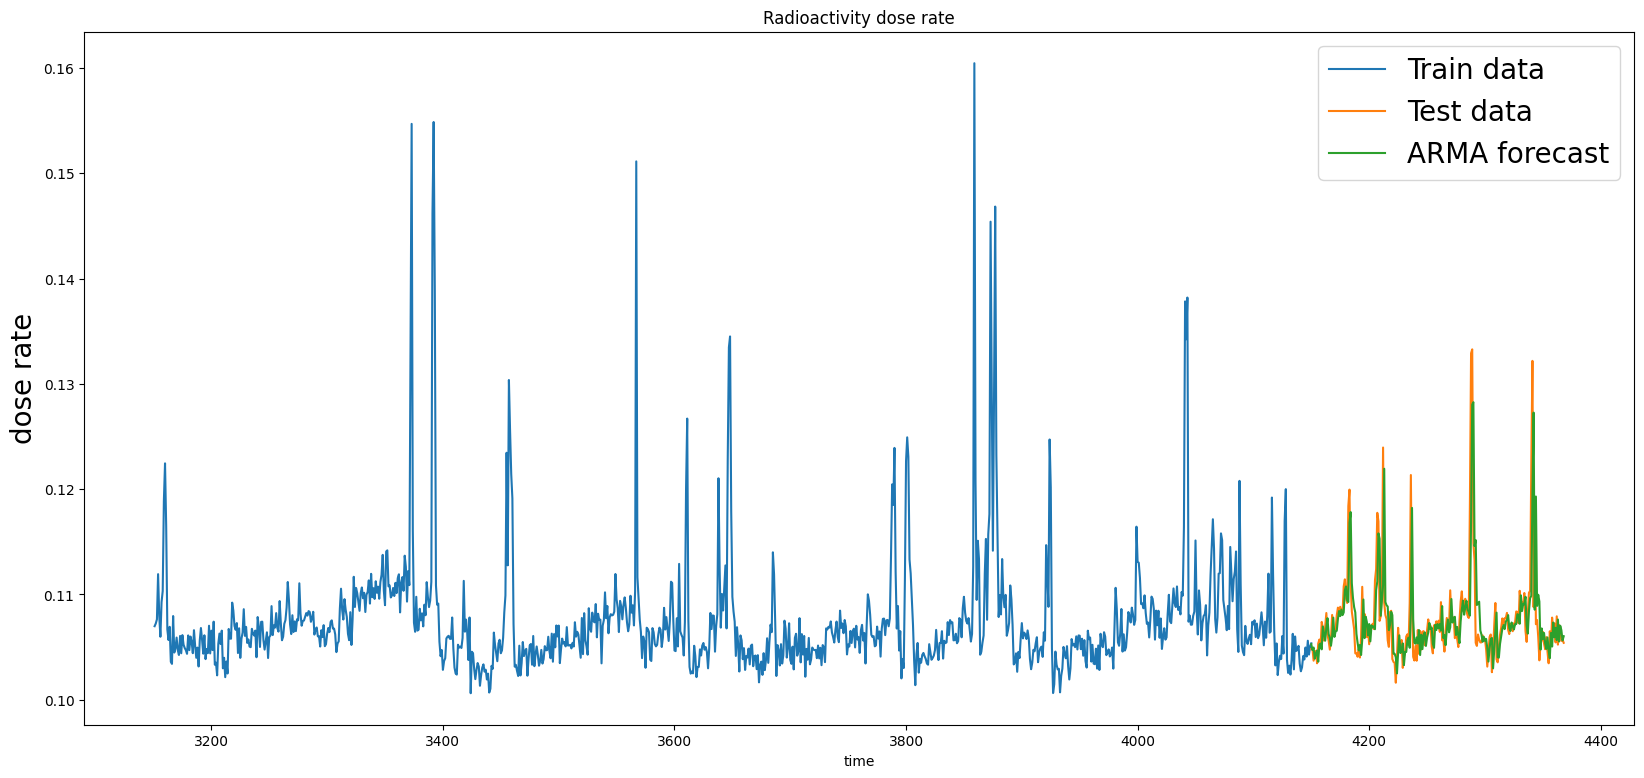

In [14]:
fig = plt.figure(figsize=(20, 9))
dur = len(arma_predictions)

plt.plot([i for i in range(size - 1000, size)], train[size - 1000:size], label='Train data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], test[:dur], label='Test data')
plt.plot([i for i in range(size - 1, size - 1 + dur)], arma_predictions, label='ARMA forecast')

plt.legend(fontsize="20")
plt.title('Radioactivity dose rate')
plt.ylabel('dose rate', fontsize="20")
plt.xlabel('time')

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

print("ARMA metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(train[size - len(arma_predictions):size], arma_predictions)))
print("MAPE:", mean_absolute_percentage_error(train[size - len(arma_predictions):size], arma_predictions))
print("MAE:", mean_absolute_error(train[size - len(arma_predictions):size], arma_predictions))
print("R2: ", r2_score(train[size - len(arma_predictions):size], arma_predictions))

ARMA metrics: 
RMSE: 0.005968545421886178
MAPE: 0.03526600116921427
MAE: 0.0038536099912435317
R2:  -0.9538213234282826


In [15]:
from IPython.display import clear_output
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left')
    plt.show()

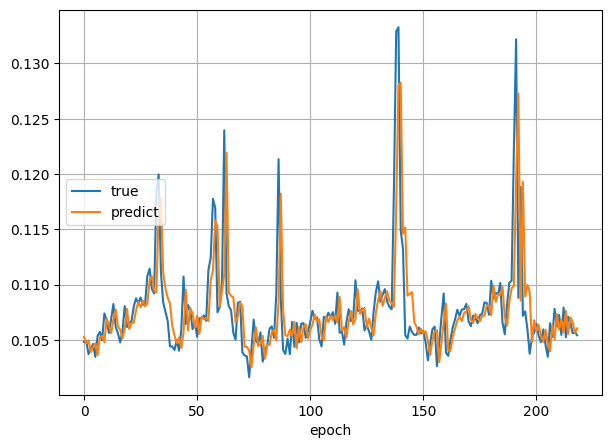

In [16]:
series = data["dose_rate"]

size = int(series.shape[0] * 0.95)
train, test = series[:size], series[size:len(series)]
history = [x for x in train.values]
predictions = []

val = {"true":[], "predict":[]}
for t in test.values:
    model = ARIMA(history, order=(5,1,0)).fit()
    output = model.forecast()
    yhat = output[0]

    predictions.append(yhat)
    val["predict"].append(yhat)
    val["true"].append(t)
    history.append(t)
    
    live_plot(val)

In [17]:
arima_model = ARIMA(data['dose_rate'], order=(10,2,10))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:              dose_rate   No. Observations:                 4370
Model:               ARIMA(10, 2, 10)   Log Likelihood               18179.959
Date:                Wed, 22 Nov 2023   AIC                         -36317.917
Time:                        18:37:35   BIC                         -36183.894
Sample:                             0   HQIC                        -36270.621
                               - 4370                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1637      0.444     -2.623      0.009      -2.033      -0.294
ar.L2         -1.1746      0.327     -3.587      0.000      -1.816      -0.533
ar.L3         -1.3324      0.389     -3.428      0.0

c:\Users\elise\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Axes: >

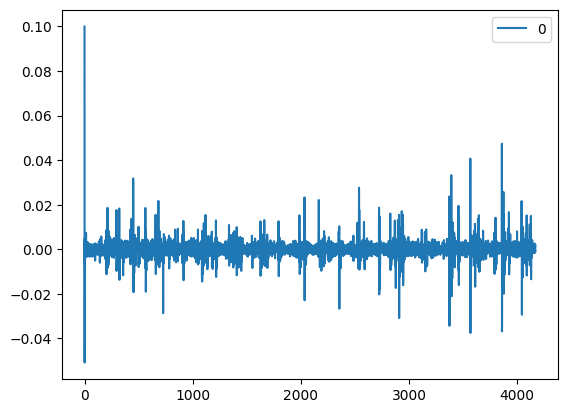

In [20]:
arima_residuals = pd.DataFrame(arima_model_fit.resid)
arima_residuals.plot()

In [ ]:
output = arima_model_fit.forecast()

X = data['dose_rate'].values
size = int(len(X) * 0.99)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
arima_predictions = list()
for t in range(len(test)):
    arima_model = ARIMA(history, order=(10,2,5))
    arima_model_fit = arima_model.fit()
    output = arima_model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

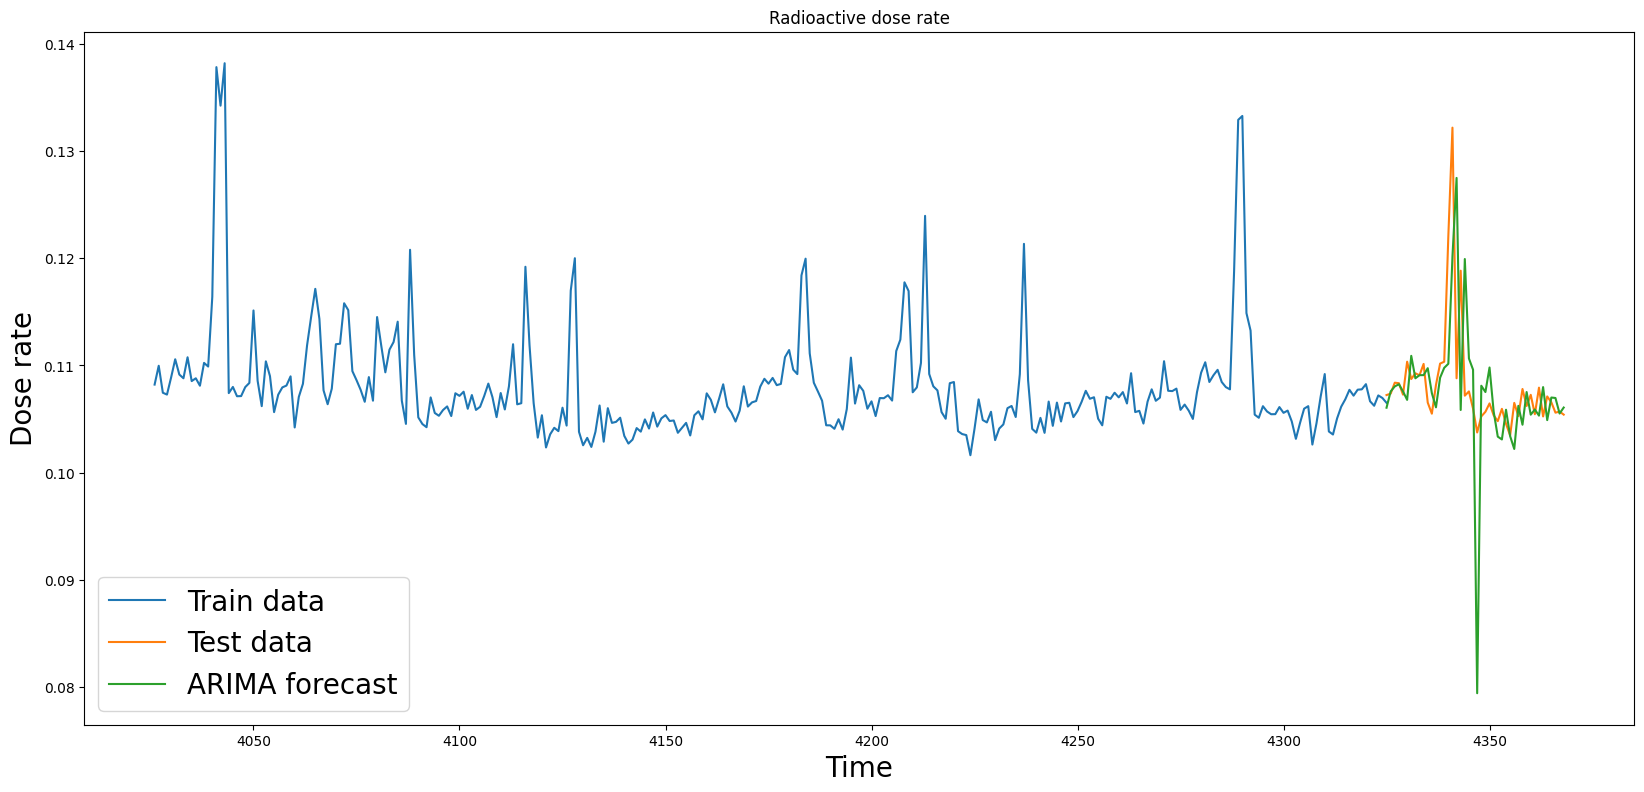

In [25]:
fig = plt.figure(figsize=(20, 9))
plt.plot([i for i in range(size - 300, size)], train[size - 300:size], label='Train data')
plt.plot([i for i in range(size - 1, len(X) - 1)], test, label='Test data')
plt.plot([i for i in range(size - 1, len(X) - 1)], arima_predictions, label='ARIMA forecast')

plt.legend(fontsize="20")
plt.title('Radioactive dose rate')
plt.ylabel('Dose rate', fontsize="20")
plt.xlabel('Time', fontsize="20")

plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

print("ARIMA metrics: ")
print("RMSE:", np.sqrt(mean_squared_error(val["predict"], val["true"])))
print("MAPE:", mean_absolute_percentage_error(val["predict"], val["true"]))
print("MAE:", mean_absolute_error(val["predict"], val["true"]))
print("R2: ", r2_score(val["predict"], val["true"]))

ARIMA metrics: 
RMSE: 0.0036986068400511702
MAPE: 0.019356942091420325
MAE: 0.0021442695191510046
R2:  0.0313628548160213


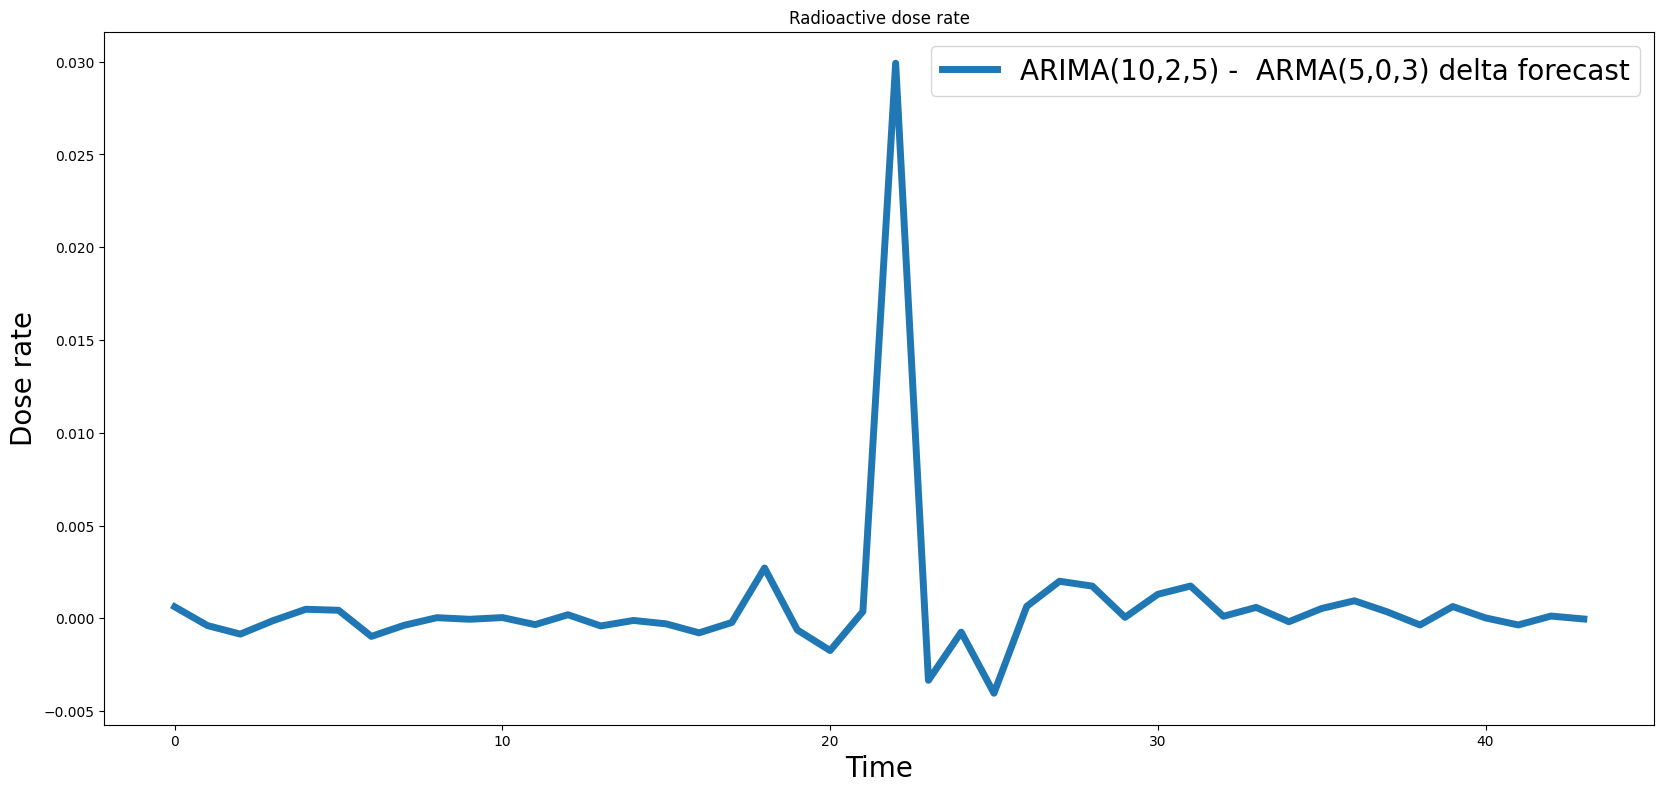

In [30]:
fig = plt.figure(figsize=(20, 9))

delta = []

for i in range(len(arima_predictions)):
    # Сдвиг из-за того, что arima_predictions меньше по размеру.
    delta.append(arma_predictions[i + 175] - arima_predictions[i])

plt.plot(delta, label='ARIMA(10,2,5) -  ARMA(5,0,3) delta forecast', linewidth=5)
plt.legend(fontsize="20")
plt.title('Radioactive dose rate')
plt.ylabel('Dose rate', fontsize="20")
plt.xlabel('Time', fontsize="20")
plt.show()

<Axes: xlabel='Time'>

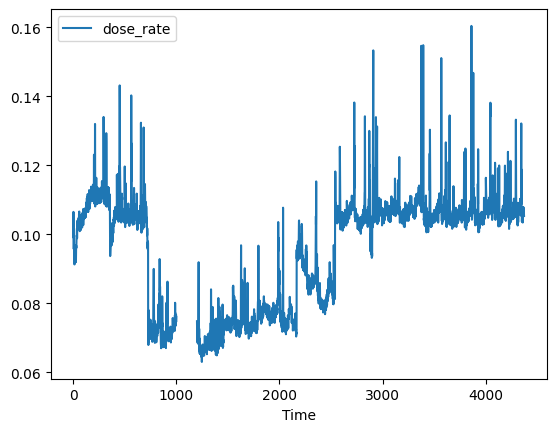

In [31]:
o_data = data.copy()
o_data = o_data.drop(columns=["MA_window_40", "MA_window_3"], axis=1)

o_data["dose_rate"][1000:1200] = np.nan

o_data.plot()

<Axes: title={'center': 'среднее из предыдущего и последующего'}, xlabel='Time'>

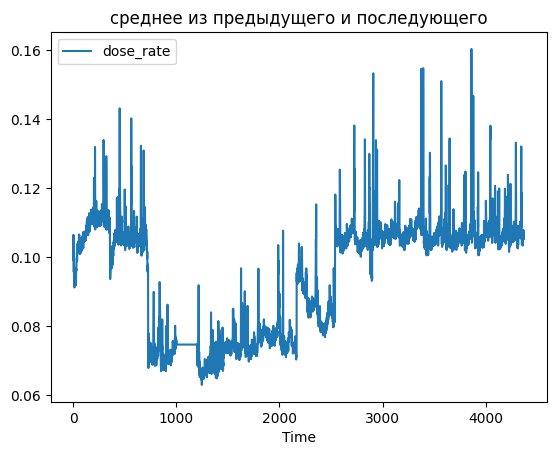

In [32]:
new_value = (o_data["dose_rate"][1201] + o_data["dose_rate"][999]) / 2
o_data["dose_rate"][1000:1200] = new_value

o_data.plot(title="среднее из предыдущего и последующего")

<Axes: title={'center': 'Последующее значение'}, xlabel='Time'>

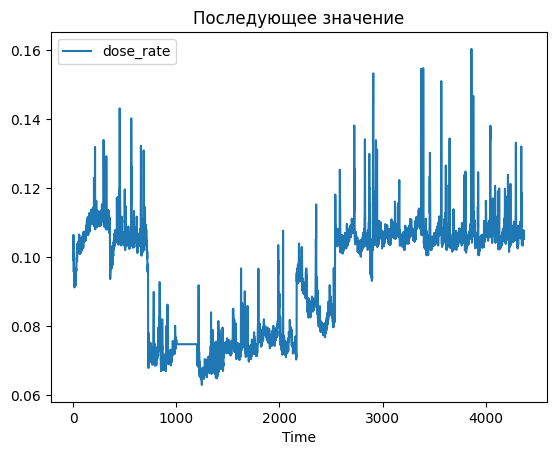

In [33]:
new_value = o_data["dose_rate"][1201]

o_data["dose_rate"][1000:1200] = new_value

o_data.plot(title='Последующее значение')

<Axes: title={'center': 'Предыдущее значение'}, xlabel='Time'>

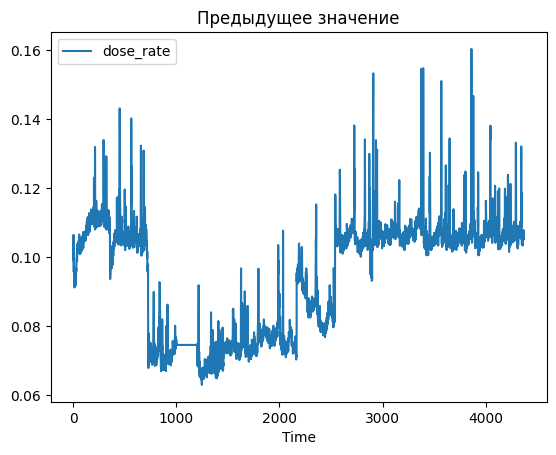

In [34]:
new_value = o_data["dose_rate"][999]

o_data["dose_rate"][1000:1200] = new_value

o_data.plot(title='Предыдущее значение')

<Axes: title={'center': 'медиана'}, xlabel='Time'>

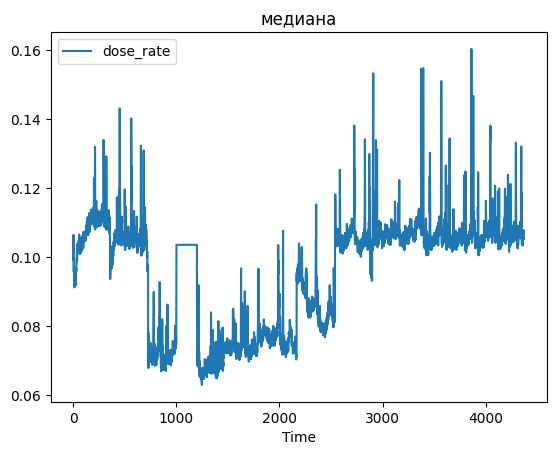

In [35]:
new_value = o_data["dose_rate"].median()

o_data["dose_rate"][1000:1200] = new_value

o_data.plot(title='медиана') 

<Axes: title={'center': 'среднее'}, xlabel='Time'>

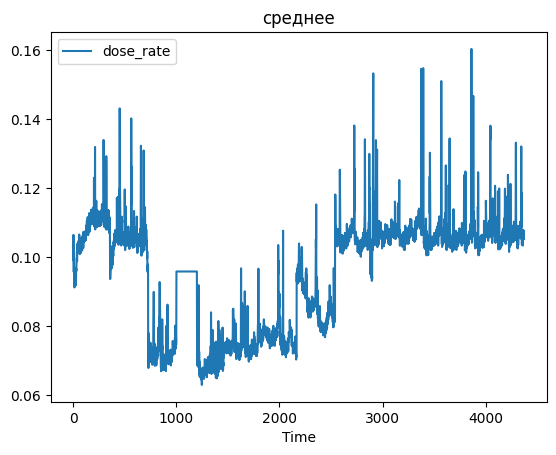

In [36]:
new_value = o_data["dose_rate"].mean()

o_data["dose_rate"][1000:1200] = new_value

o_data.plot(title='среднее') 

<Axes: title={'center': 'zero'}, xlabel='Time'>

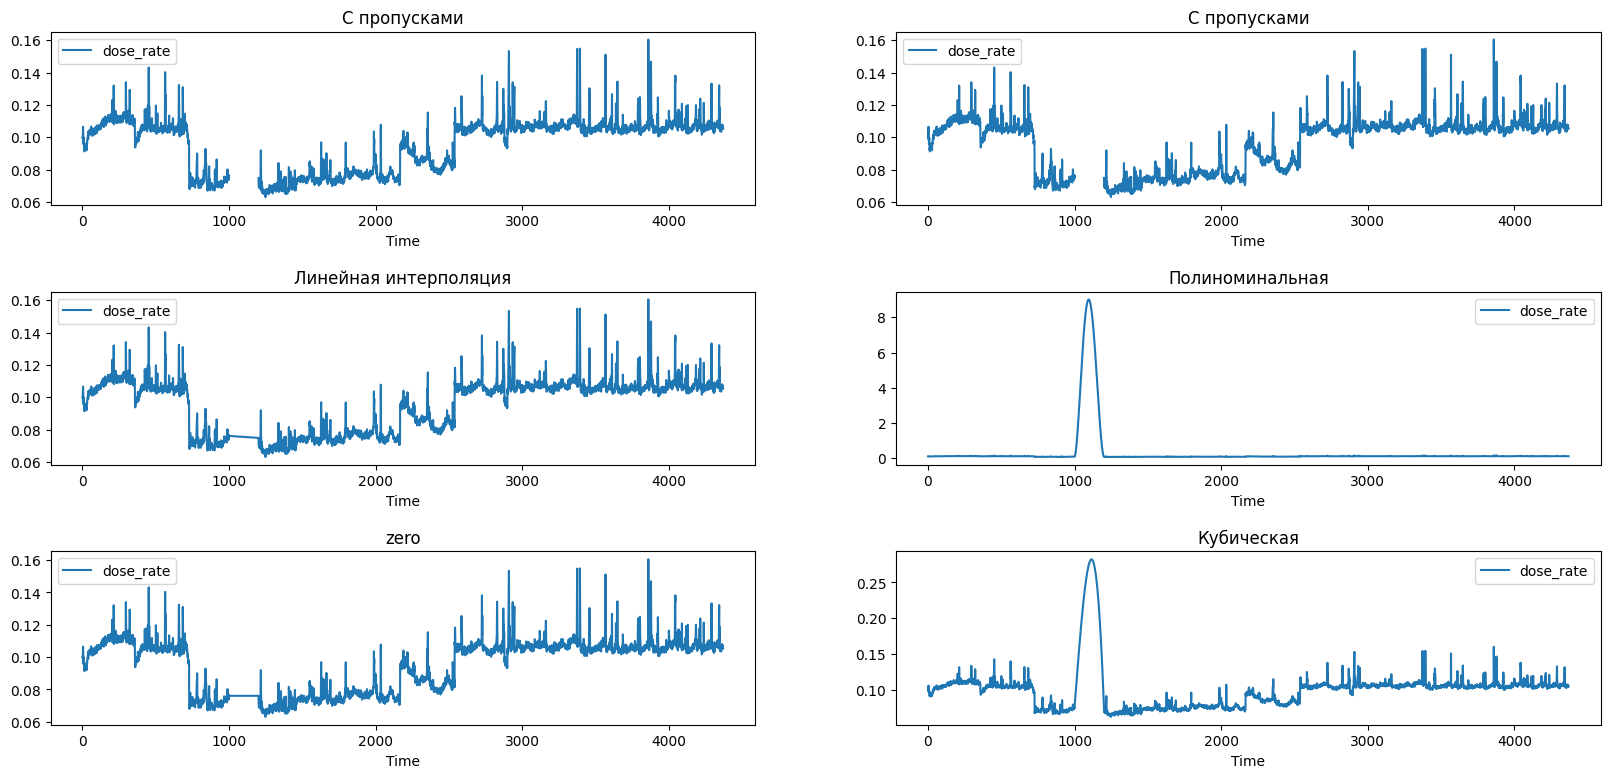

In [37]:
o_data["dose_rate"][1000:1200] = np.nan

lin_df = o_data.interpolate(method="linear")

cub_df = o_data.interpolate(method="cubic")

pol_df = o_data.interpolate(method="polynomial", order=5)

zero_df = o_data.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))
 
o_data.plot(title="С пропусками", ax = original_ax)  
o_data.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))  
lin_df.plot(title="Линейная интерполяция", ax = lin_ax) 
cub_df.plot(title="Кубическая", ax = cub_ax) 
pol_df.plot(title="Полиноминальная", ax = pol_ax) 
zero_df.plot(title="zero", ax=zero_ax)

<Axes: >

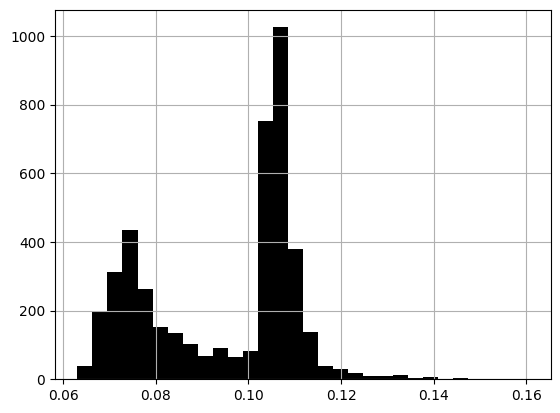

In [38]:
import seaborn as sns

data["dose_rate"].hist(bins=30, color="black")

Text(0.5, 1.0, 'dose_rate')

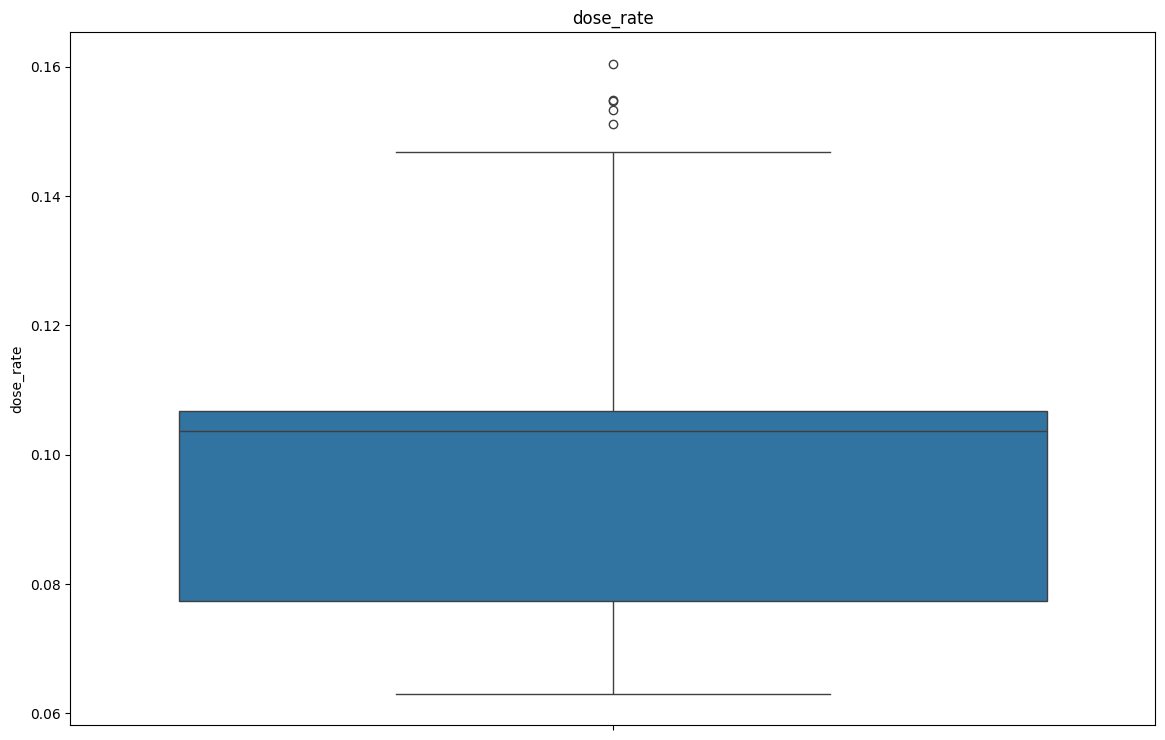

In [39]:
fig = plt.figure(figsize=(14, 9))
 
sns.boxplot(data.dose_rate).set_title('dose_rate')

In [40]:
from sklearn import preprocessing, svm

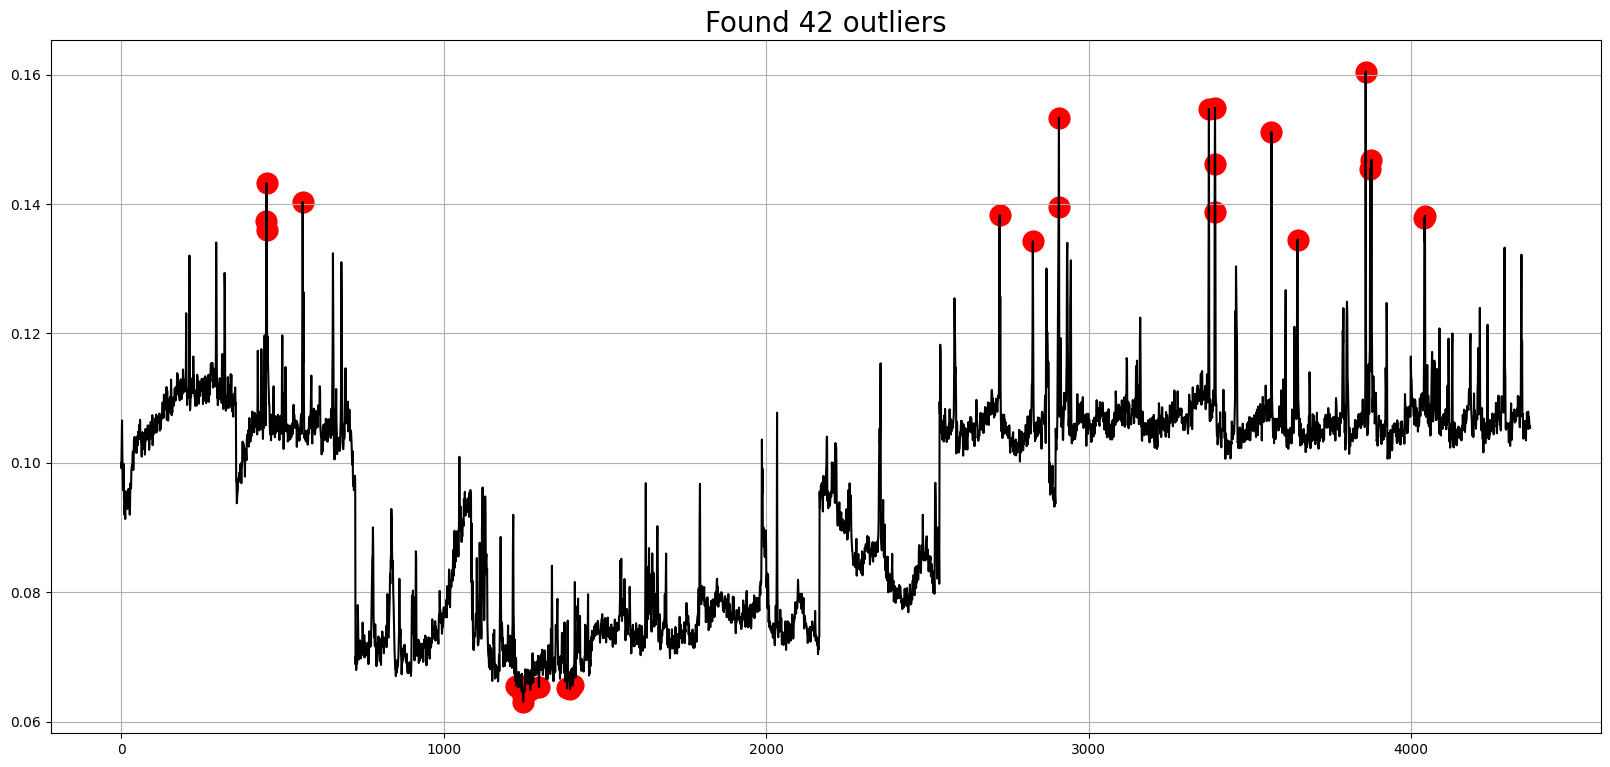

In [41]:
scaler = preprocessing.StandardScaler()
perc = 0.01

local_df = data["dose_rate"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)

dtf_outliers =local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda x: 1 if x==-1 else 0)

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
        color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

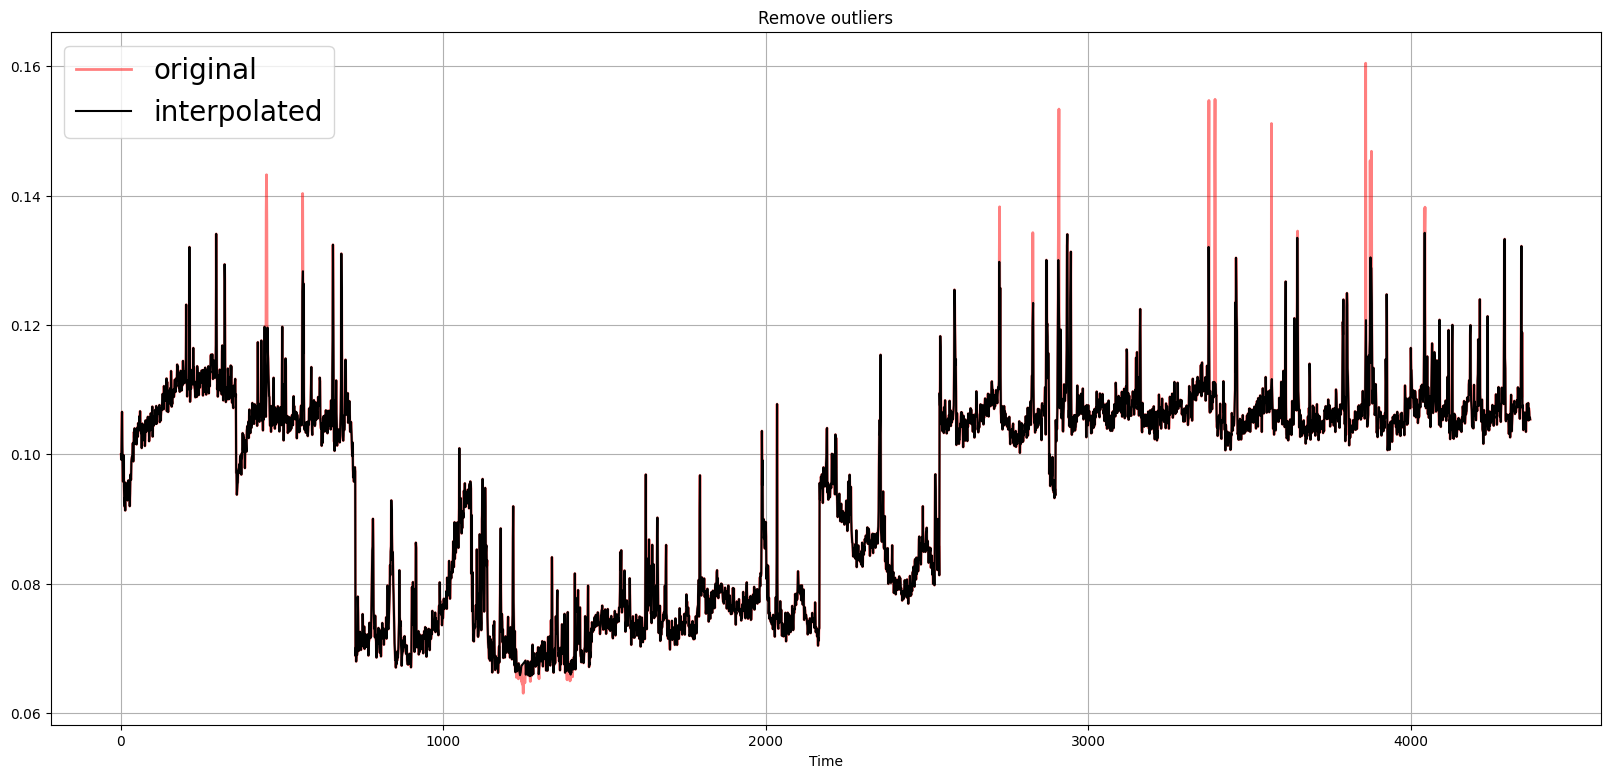

In [42]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_clean = local_df.copy()
ts_clean.loc[outliers_idx] = np.nan
ts_clean = ts_clean.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Remove outliers", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()